In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc
    
import pickle
import csv

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# The following code is for random generation of colors.
# See here: https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np

    np.random.seed(seed=10)
    np.random.RandomState(seed=10)

    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal('./datasets/ppi_mips.graphml','graphml',' ')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.
g.discard_weights()

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/ppi_mips.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/ppi_mips_coordinates.xy', dtype = 'str')

temp = []
for i in ld_coord:
    temp.append(i[0])

idxs = dict(zip(temp, range(len(temp)))) 

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [6]:
g_v_prop = g_gtool.vertex_properties
groups = np.loadtxt('./datasets/ppi_mips.class', dtype = 'float')
feature_list = [groups]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 100:
            continue
            
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 100:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_ppi_mips', ref_nodes) 
            np.save('results/info_ref_nodes_ppi_mips', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 0 Feature value  2.0  gap  [0.99978071]  volume:  431.0  size: 18 conductance:  0.2900232018561485
Reached
Number of feature 0 Feature value  28.0  gap  [0.99989145]  volume:  1253.0  size: 33 conductance:  0.15722266560255388
Reached
Number of feature 0 Feature value  77.0  gap  [0.99992007]  volume:  703.0  size: 22 conductance:  0.34281650071123754
Reached
Number of feature 0 Feature value  80.0  gap  [0.99254188]  volume:  120.0  size: 11 conductance:  0.08333333333333333
Reached
Number of feature 0 Feature value  82.0  gap  [0.99905485]  volume:  1023.0  size: 32 conductance:  0.030303030303030304
Reached
Number of feature 0 Feature value  83.0  gap  [0.88073807]  volume:  106.0  size: 9 conductance:  0.32075471698113206
Reached
Number of feature 0 Feature value  87.0  gap  [0.99586883]  volume:  224.0  size: 15 conductance:  0.0625
Reached
Number of feature 0 Feature value  99.0  gap  [0.99927466]  volume:  103.0  size: 8 conductance:  0.4563106796116505

In [7]:
ref_nodes = np.load('results/ref_nodes_ppi_mips.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_ppi_mips.npy') 

In [8]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
    
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("vector<double>")

c_map = rand_cmap(n, type='bright', first_color_black=False, last_color_black=False, verbose=False)

for i in range(n):
    node_colours[i] = [0,0,0]

counter = 0

for i in ref_nodes:
    
    for j in i:
        node_colours[j] = c_map(int(info_ref_nodes[counter,1]))
    counter += 1

#def get_cmap(n, name='hsv'):
#    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#    RGB color; the keyword argument name must be a standard mpl colormap name.'''
#    return plt.cm.get_cmap(name, n)

#c_map = get_cmap(g_gtool.num_vertices())

#c_map = rand_cmap(n, type='bright', first_color_black=True, last_color_black=False, verbose=True)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.05],
           output='figures/ppi_mips_selected.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13ce040f0, at 0x13cdf7fd0>

Running ppimips
There are  1  connected components in the graph
approxPageRank:ncpapr_acl:    0.3 neighborhoods
approxPageRank:ncpapr_acl:    1.5 localmin rho=1.0e-05
approxPageRank:ncpapr_acl:    1.8 localmin rho=1.0e-04
approxPageRank:ncpapr_acl:   55.7 random_node rho=1.0e-05
approxPageRank:ncpapr_acl:   62.9 random_node rho=1.0e-04
approxPageRank:ncpapr_acl:  116.4 random_neighborhood rho=1.0e-05
approxPageRank:ncpapr_acl:  130.2 random_neighborhood rho=1.0e-04


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

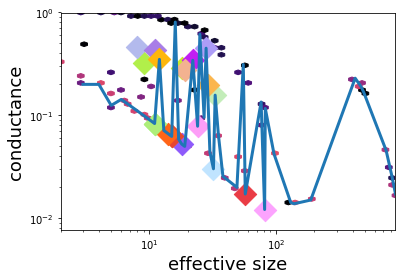

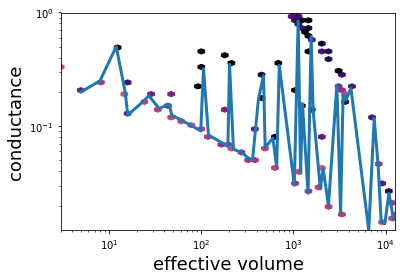

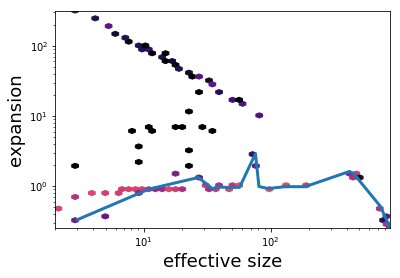

In [9]:
print("Running ppimips")

ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=1,timeout=5000000,nthreads=24)
ncp_instance.add_set_samples_without_method(ref_nodes)

ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "")
#plot conductance vs size
fig, ax, min_tuples = ncp_plots.cond_by_size()
counter = 0
for cluster in ref_nodes:
    ax.scatter([len(cluster)], [g.compute_conductance(cluster,cpp=True)], c=c_map(int(info_ref_nodes[counter,1])), s=250, marker='D')
    counter += 1
plt.savefig('figures/cond_card_ppimips.png', bbox_inches='tight')
plt.show()
#plot conductance vs volume
fig, ax, min_tuples = ncp_plots.cond_by_vol()
plt.savefig('figures/cond_vol_ppimips.png', bbox_inches='tight')
plt.show()
#plot isoperimetry vs size
fig, ax, min_tuples = ncp_plots.isop_by_size()
plt.savefig('figures/expand_card_ppimips.png', bbox_inches='tight')
plt.show()

pickle.dump(ncp_instance, open('results/ncp-ppimips.pickle', 'wb'))

In [10]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh.graphml','graphml',' ')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



In [11]:
g_gtool = load_graph('datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

In [12]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh_coordinates.xy', dtype = 'str')

temp = []
for i in ld_coord:
    temp.append(i[0])

idxs = dict(zip(temp, range(len(temp)))) 

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3]

In [13]:
g_v_prop = g_gtool.vertex_properties
groups = np.loadtxt('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh.class', dtype = 'float')
feature_list = [groups]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 100:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 100:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_sfld', ref_nodes) 
            np.save('results/info_ref_nodes_sfld', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 0 Feature value  22.0  gap  [0.91796738]  volume:  16209.0  size: 100 conductance:  0.42254370102471367


In [14]:
ref_nodes = np.load('results/ref_nodes_sfld.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_sfld.npy') 

In [15]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
    
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in ref_nodes[0]:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

#def get_cmap(n, name='hsv'):
#    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#    RGB color; the keyword argument name must be a standard mpl colormap name.'''
#    return plt.cm.get_cmap(name, n)

#c_map = get_cmap(g_gtool.num_vertices())

#c_map = rand_cmap(n, type='bright', first_color_black=True, last_color_black=False, verbose=True)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/sfld_selected.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1427db3c8, at 0x1427c9ac8>

Running sfld
There are  1  connected components in the graph


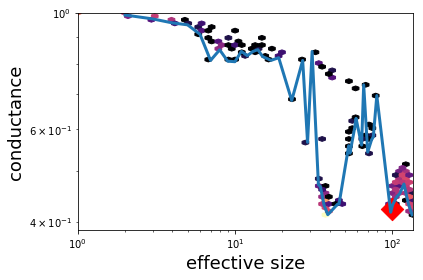

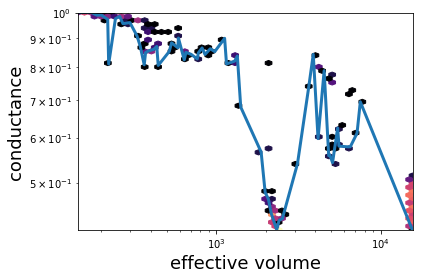

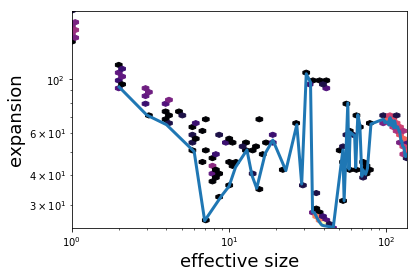

In [16]:
print("Running sfld")

ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=1,timeout=5000000,nthreads=12)
ncp_instance.add_set_samples_without_method(ref_nodes)

ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "")
#plot conductance vs size
fig, ax, min_tuples = ncp_plots.cond_by_size()
counter = 0
for cluster in ref_nodes:
    ax.scatter([len(cluster)], [g.compute_conductance(cluster,cpp=True)], c="red", s=250, marker='D')
    counter += 1
plt.savefig('figures/cond_card_sfld.png', bbox_inches='tight')
plt.show()
#plot conductance vs volume
fig, ax, min_tuples = ncp_plots.cond_by_vol()
plt.savefig('figures/cond_vol_sfld.png', bbox_inches='tight')
plt.show()
#plot isoperimetry vs size
fig, ax, min_tuples = ncp_plots.isop_by_size()
plt.savefig('figures/expand_card_sfld.png', bbox_inches='tight')
plt.show()

pickle.dump(ncp_instance, open('results/ncp-sfld.pickle', 'wb'))

In [17]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



In [18]:
g_gtool = load_graph('datasets/JohnsHopkins.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

In [ ]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g_gtool.num_vertices()):
    pos[i] = ld_coord[idx[i],1:3]

In [ ]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 1000:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 100:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_JH', ref_nodes) 
            np.save('results/info_ref_nodes_JH', info_ref_nodes) 
        
    number_feature += 1

In [ ]:
ref_nodes = np.load('results/ref_nodes_JH.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_JH.npy') 

In [ ]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]
    
temp = ["black" for x in range(g._num_vertices)]

for i in ref_nodes[0]:
    temp[i] = "orange"
for i in ref_nodes[1]:
    temp[i] = "blue"
for i in ref_nodes[2]:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

node_text = g_gtool.new_vertex_property("string")
node_order = g_gtool.new_vertex_property("int")
node_text_offset = g_gtool.new_vertex_property("vector<double>")
node_text_color = g_gtool.new_vertex_property("string")

for i in range(g._num_vertices):
    node_text_color[i] = "black"

node_text[4069] = "Students of year 2009"
node_order[4069] = 10
node_text_offset[4069] = [0,0]#[-0.5,23]
node_text_color[4069]="red"

node_text[1453] = "Students with major index 217"
node_order[1453] = 10
node_text_offset[1453] = [-0.5,15]
node_text_color[1453]="orange"

node_text[4633] = "Students of year 2008"
node_order[4633] = 10
node_text_offset[4633] = [0,0]#[-0.5,23]
node_text_color[4633]="blue"

# Plot solutions for rounded eigenvector
graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=3,
           vertex_fill_color=node_colours,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vorder=node_order,
           vertex_text=node_text,
           vertex_text_position=1,
           vertex_font_size=20,
           vertex_text_offset=node_text_offset,
           vertex_text_color=node_text_color,
           output='figures/JohnsHopkins_selected_features.png'
          )

In [ ]:
print("Running JohnsHopkins")

ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.8,timeout=5000000,nthreads=12)
ncp_instance.add_set_samples_without_method(ref_nodes)

ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "")
#plot conductance vs size
fig, ax, min_tuples = ncp_plots.cond_by_size()
ax.scatter([len(ref_nodes[0])], [g.compute_conductance(ref_nodes[0],cpp=True)], c="orange", s=250, marker='D')
ax.scatter([len(ref_nodes[1])], [g.compute_conductance(ref_nodes[1],cpp=True)], c="blue", s=250, marker='D')
ax.scatter([len(ref_nodes[2])], [g.compute_conductance(ref_nodes[2],cpp=True)], c="red", s=250, marker='D')
plt.savefig('figures/cond_card_johns.png', bbox_inches='tight')
plt.show()
#plot conductance vs volume
fig, ax, min_tuples = ncp_plots.cond_by_vol()
plt.savefig('figures/cond_vol_johns.png', bbox_inches='tight')
plt.show()
#plot isoperimetry vs size
fig, ax, min_tuples = ncp_plots.isop_by_size()
plt.savefig('figures/expand_card_johns.png', bbox_inches='tight')
plt.show()

pickle.dump(ncp_instance, open('results/ncp-johns.pickle', 'wb'))

In [ ]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/Colgate88_reduced.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

In [ ]:
g_gtool = load_graph('datasets/Colgate88_reduced.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

In [ ]:
# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(n):
    pos[i] = [xx[i],yy[i]]

In [ ]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 100:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 100:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_Colgate88', ref_nodes) 
            np.save('results/info_ref_nodes_Colgate88', info_ref_nodes) 
        
    number_feature += 1

In [ ]:
ref_nodes = np.load('results/ref_nodes_Colgate88.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_Colgate88.npy') 

In [ ]:
# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g_gtool.num_vertices()):
    pos[i] = [xx[i],yy[i]]
    
temp = ["black" for x in range(g._num_vertices)]

#for i in ref_nodes[0]:
#    temp[i] = "green"
for i in ref_nodes[1]:
    temp[i] = "blue"
for i in ref_nodes[2]:
    temp[i] = "orange"
for i in ref_nodes[3]:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

node_text = g_gtool.new_vertex_property("string")
node_order = g_gtool.new_vertex_property("int")
node_text_offset = g_gtool.new_vertex_property("vector<double>")
node_text_color = g_gtool.new_vertex_property("string")
node_text_position = g_gtool.new_vertex_property("int")

for i in range(g._num_vertices):
    node_text_color[i] = "black"

node_text[2651] = "Students of year 2008"
node_order[2651] = 10
node_text_offset[2651] = [-1,-30]
node_text_color[2651] = "orange"
node_text_position[2651] = 1.57

node_text[2115] = "Students of year 2009"
node_order[2115] = 10
node_text_offset[2115] = [2,13]
node_text_color[2115] = "red"
node_text_position[2115] = 1

node_text[2905] = "Students of year 2007"
node_order[2905] = 10
node_text_offset[2905] = [-0.5,23]
node_text_color[2905] = "blue"
node_text_position[2905] = 1

#node_text[230] = "Students of year 2006"
#node_order[230] = 10
#node_text_offset[230] = [-0.5,15]
#node_text_color[230] = "green"
#node_text_position[230] = 1

# Plot solutions for rounded eigenvector
graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=3,
           vertex_fill_color=node_colours,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vorder=node_order,
           vertex_text=node_text,
           vertex_text_position=node_text_position,
           vertex_font_size=20,
           vertex_text_offset=node_text_offset,
           vertex_text_color=node_text_color,
           output='figures/colgate_selected_features.png')

In [ ]:
print("Running Colgate")

ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.8,timeout=5000000,nthreads=12)
ncp_instance.add_set_samples_without_method(ref_nodes)

ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "")
#plot conductance vs size
fig, ax, min_tuples = ncp_plots.cond_by_size()
ax.scatter([len(ref_nodes[0])], [g.compute_conductance(ref_nodes[0],cpp=True)], c="orange", s=250, marker='D')
ax.scatter([len(ref_nodes[1])], [g.compute_conductance(ref_nodes[1],cpp=True)], c="blue", s=250, marker='D')
ax.scatter([len(ref_nodes[2])], [g.compute_conductance(ref_nodes[2],cpp=True)], c="red", s=250, marker='D')
plt.savefig('figures/cond_card_colgate.png', bbox_inches='tight')
plt.show()
#plot conductance vs volume
fig, ax, min_tuples = ncp_plots.cond_by_vol()
plt.savefig('figures/cond_vol_colgate.png', bbox_inches='tight')
plt.show()
#plot isoperimetry vs size
fig, ax, min_tuples = ncp_plots.isop_by_size()
plt.savefig('figures/expand_card_colgate.png', bbox_inches='tight')
plt.show()

pickle.dump(ncp_instance, open('results/ncp-colgate.pickle', 'wb'))